In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

## Data Generating Process (DGP)

We'll create a sparse linear model where only a few predictors have non-zero coefficients.

In [ ]:
# Set parameters for the data generating process
n_samples = 200        # Number of observations
n_features = 50        # Total number of features
n_informative = 10      # Number of features with non-zero coefficients
noise_level = 1.0       # Standard deviation of the noise

# Generate feature matrix X
# Each column is a feature drawn from standard normal distribution
X = np.random.randn(n_samples, n_features)

# Create the true coefficient vector (beta)
# Most coefficients are zero (sparse model)
true_coefficients = np.zeros(n_features)

# Randomly select which features will have non-zero coefficients
informative_features = np.random.choice(n_features, n_informative, replace=False)
print(f"True informative features indices: {sorted(informative_features)}")

# Assign non-zero values to selected coefficients
# Values are drawn from a normal distribution with larger variance
for idx in informative_features:
    true_coefficients[idx] = np.random.randn() * 3

# Generate the response variable Y
# Y = X * beta + noise
Y = X @ true_coefficients + np.random.randn(n_samples) * noise_level

# Save the data and true coefficients for later analysis
data_dict = {
    'X': X,
    'Y': Y,
    'true_coefficients': true_coefficients,
    'informative_features': informative_features
}

# Create a DataFrame to better visualize the coefficients
coef_df = pd.DataFrame({
    'feature_index': range(n_features),
    'true_coefficient': true_coefficients
})

# Show the non-zero coefficients
print("\nNon-zero coefficients:")
print(coef_df[coef_df['true_coefficient'] != 0])

True informative features indices: [np.int64(0), np.int64(2), np.int64(4), np.int64(10), np.int64(15), np.int64(17), np.int64(19), np.int64(23), np.int64(44), np.int64(45)]

Non-zero coefficients:
    feature_index  true_coefficient
0               0         -5.038946
2               2         -2.678609
4               4         -1.823795
10             10         -1.610677
15             15         -2.561768
17             17          0.393326
19             19          1.786967
23             23          5.059156
44             44         -0.493334
45             45          5.933621


## Train-Test Split

Split the data into training and testing sets to evaluate model performance.

In [ ]:
# Split the data into training and testing sets
# We use 70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Standardize the features (important for regularized regression)
# Fit the scaler on training data and apply to both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set size: (140, 50)
Test set size: (60, 50)


## Implementing Lasso Regression

### Understanding Lasso

Lasso adds an L1 penalty to the ordinary least squares objective:

$$\min_{\beta} \frac{1}{2n} ||Y - X\beta||_2^2 + \alpha ||\beta||_1$$

where:
- $\alpha$ is the regularization parameter
- $||\beta||_1 = \sum_{j=1}^p |\beta_j|$ is the L1 norm

In [ ]:
# Define different alpha values to test
# Alpha controls the strength of regularization
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

# Store results for each alpha
lasso_results = {}

for alpha in alphas:
    # Create and fit Lasso model
    # max_iter: maximum number of iterations for optimization
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, Y_train)

    # Make predictions
    Y_train_pred = lasso.predict(X_train_scaled)
    Y_test_pred = lasso.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)

    # Count non-zero coefficients
    n_nonzero = np.sum(lasso.coef_ != 0)

    # Store results
    lasso_results[alpha] = {
        'model': lasso,
        'coefficients': lasso.coef_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_nonzero_coef': n_nonzero
    }

    print(f"\nAlpha = {alpha}")
    print(f"  Non-zero coefficients: {n_nonzero}")
    print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


Alpha = 0.0001
  Non-zero coefficients: 50
  Train MSE: 0.6324, Test MSE: 1.4795
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.001
  Non-zero coefficients: 50
  Train MSE: 0.6324, Test MSE: 1.4605
  Train R²: 0.9952, Test R²: 0.9874

Alpha = 0.01
  Non-zero coefficients: 49
  Train MSE: 0.6408, Test MSE: 1.3003
  Train R²: 0.9951, Test R²: 0.9888

Alpha = 0.1
  Non-zero coefficients: 19
  Train MSE: 0.9011, Test MSE: 1.0314
  Train R²: 0.9931, Test R²: 0.9911

Alpha = 0.5
  Non-zero coefficients: 8
  Train MSE: 3.3757, Test MSE: 3.0970
  Train R²: 0.9743, Test R²: 0.9733

Alpha = 1.0
  Non-zero coefficients: 8
  Train MSE: 8.9801, Test MSE: 9.0886
  Train R²: 0.9316, Test R²: 0.9216


## Implementing Ridge Regression

### Understanding Ridge

Ridge adds an L2 penalty to the ordinary least squares objective:

$$\min_{\beta} \frac{1}{2n} ||Y - X\beta||_2^2 + \alpha ||\beta||_2^2$$

where:
- $||\beta||_2^2 = \sum_{j=1}^p \beta_j^2$ is the squared L2 norm

In [ ]:
# Store Ridge results for comparison
ridge_results = {}

for alpha in alphas:
    # Create and fit Ridge model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)

    # Make predictions
    Y_train_pred = ridge.predict(X_train_scaled)
    Y_test_pred = ridge.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)

    # For Ridge, count "effectively zero" coefficients (very small)
    threshold = 0.001
    n_small = np.sum(np.abs(ridge.coef_) < threshold)

    # Store results
    ridge_results[alpha] = {
        'model': ridge,
        'coefficients': ridge.coef_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_small_coef': n_small
    }

    print(f"\nAlpha = {alpha}")
    print(f"  Coefficients < {threshold}: {n_small}")
    print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


Alpha = 0.0001
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4816
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.001
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4816
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.01
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4812
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.1
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4778
  Train R²: 0.9952, Test R²: 0.9873

Alpha = 0.5
  Coefficients < 0.001: 0
  Train MSE: 0.6343, Test MSE: 1.4666
  Train R²: 0.9952, Test R²: 0.9873

Alpha = 1.0
  Coefficients < 0.001: 1
  Train MSE: 0.6402, Test MSE: 1.4614
  Train R²: 0.9951, Test R²: 0.9874


## Visualizing Coefficient Recovery

Let's visualize how well each method recovers the true coefficients.

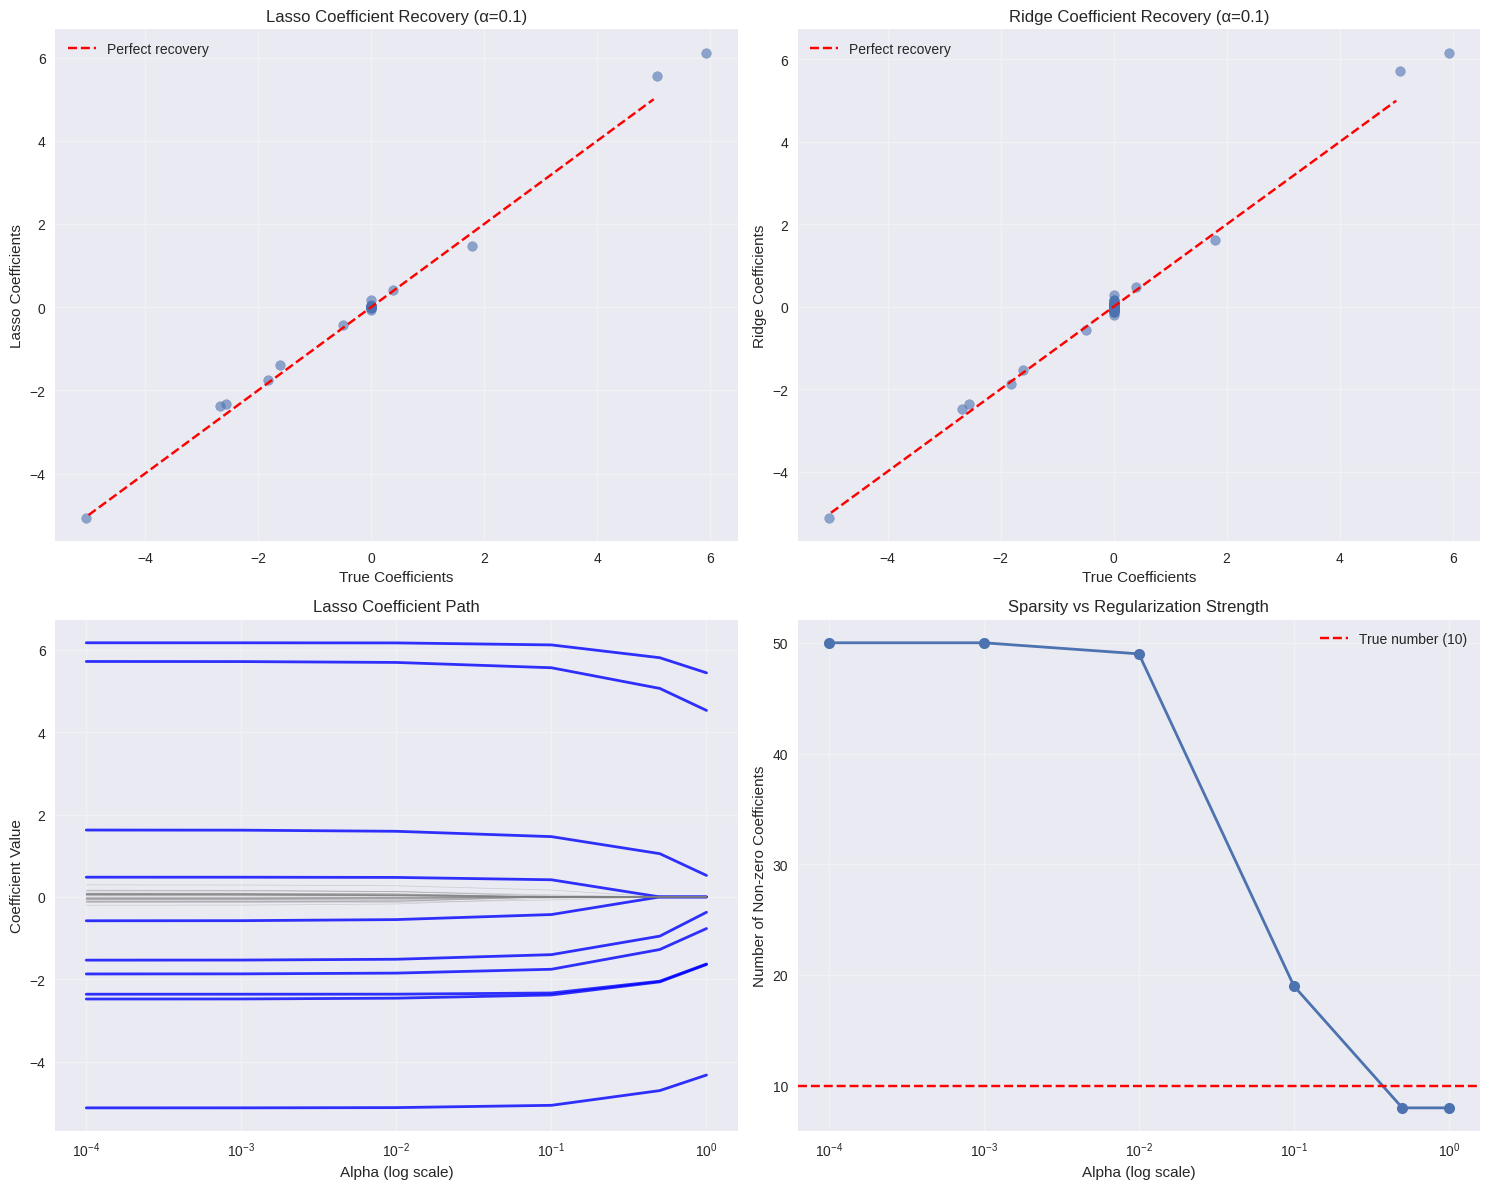

In [ ]:
# Select a specific alpha for detailed comparison
selected_alpha = 0.1

# Get the coefficients for the selected alpha
lasso_coef = lasso_results[selected_alpha]['coefficients']
ridge_coef = ridge_results[selected_alpha]['coefficients']

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Lasso coefficients vs True coefficients
ax1 = axes[0, 0]
ax1.scatter(true_coefficients, lasso_coef, alpha=0.6)
ax1.plot([-5, 5], [-5, 5], 'r--', label='Perfect recovery')
ax1.set_xlabel('True Coefficients')
ax1.set_ylabel('Lasso Coefficients')
ax1.set_title(f'Lasso Coefficient Recovery (α={selected_alpha})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Ridge coefficients vs True coefficients
ax2 = axes[0, 1]
ax2.scatter(true_coefficients, ridge_coef, alpha=0.6)
ax2.plot([-5, 5], [-5, 5], 'r--', label='Perfect recovery')
ax2.set_xlabel('True Coefficients')
ax2.set_ylabel('Ridge Coefficients')
ax2.set_title(f'Ridge Coefficient Recovery (α={selected_alpha})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Coefficient path for Lasso
ax3 = axes[1, 0]
for idx in informative_features:
    coef_path = [lasso_results[alpha]['coefficients'][idx] for alpha in alphas]
    ax3.plot(alphas, coef_path, 'b-', linewidth=2, alpha=0.8)
# Plot non-informative features in lighter color
for idx in range(n_features):
    if idx not in informative_features:
        coef_path = [lasso_results[alpha]['coefficients'][idx] for alpha in alphas]
        ax3.plot(alphas, coef_path, 'gray', linewidth=0.5, alpha=0.3)
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (log scale)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Lasso Coefficient Path')
ax3.grid(True, alpha=0.3)

# Plot 4: Number of non-zero coefficients vs alpha
ax4 = axes[1, 1]
nonzero_counts = [lasso_results[alpha]['n_nonzero_coef'] for alpha in alphas]
ax4.plot(alphas, nonzero_counts, 'o-', linewidth=2, markersize=8)
ax4.axhline(y=n_informative, color='r', linestyle='--',
            label=f'True number ({n_informative})')
ax4.set_xscale('log')
ax4.set_xlabel('Alpha (log scale)')
ax4.set_ylabel('Number of Non-zero Coefficients')
ax4.set_title('Sparsity vs Regularization Strength')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cross-Validation for Optimal Alpha

Use cross-validation to find the optimal regularization parameter.

Optimal alpha from cross-validation: 0.0735
Test MSE with optimal alpha: 1.0446
Test R² with optimal alpha: 0.9910


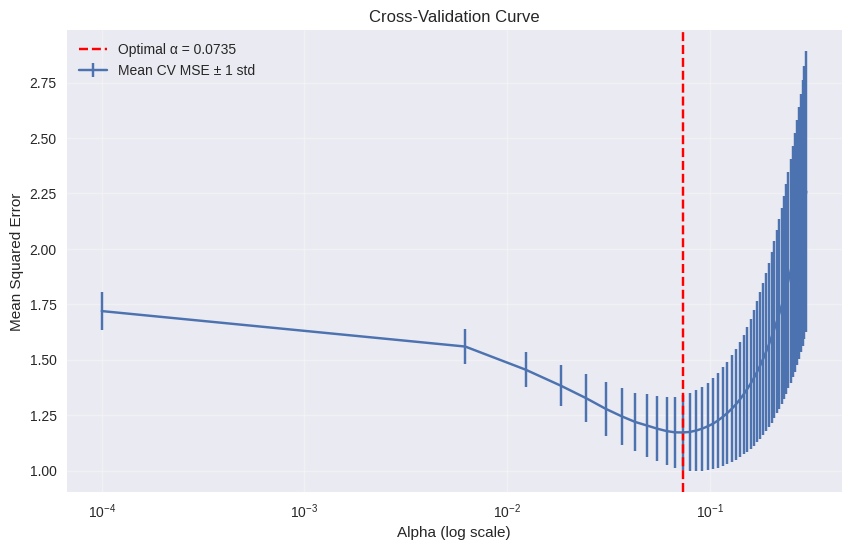

In [ ]:
# Use LassoCV for automatic alpha selection
from sklearn.linear_model import LassoCV

# Define a range of alphas to test
alphas_cv = np.linspace(0.0001, 0.3, 50)

# Perform cross-validation
# cv=5 means 5-fold cross-validation
lasso_cv = LassoCV(alphas=alphas_cv, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, Y_train)

# Get the optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha from cross-validation: {optimal_alpha:.4f}")

# Evaluate the model with optimal alpha
Y_test_pred_cv = lasso_cv.predict(X_test_scaled)
test_mse_cv = mean_squared_error(Y_test, Y_test_pred_cv)
test_r2_cv = r2_score(Y_test, Y_test_pred_cv)

print(f"Test MSE with optimal alpha: {test_mse_cv:.4f}")
print(f"Test R² with optimal alpha: {test_r2_cv:.4f}")


# Plot the cross-validation curve
plt.figure(figsize=(10, 6))
plt.errorbar(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1),
            yerr=lasso_cv.mse_path_.std(axis=1),
            label='Mean CV MSE ± 1 std')
plt.axvline(x=optimal_alpha, color='r', linestyle='--',
           label=f'Optimal α = {optimal_alpha:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

In [ ]:
# Create a summary comparison
summary_data = []

# Add Lasso results
for alpha in alphas:
    summary_data.append({
        'Method': 'Lasso',
        'Alpha': alpha,
        'Test MSE': lasso_results[alpha]['test_mse'],
        'Test R²': lasso_results[alpha]['test_r2'],
        'Non-zero Coefficients': lasso_results[alpha]['n_nonzero_coef']
    })

# Add Ridge results
for alpha in alphas:
    summary_data.append({
        'Method': 'Ridge',
        'Alpha': alpha,
        'Test MSE': ridge_results[alpha]['test_mse'],
        'Test R²': ridge_results[alpha]['test_r2'],
        'Non-zero Coefficients': n_features  # Ridge doesn't set coefficients to zero
    })

# Add CV Lasso result
summary_data.append({
    'Method': 'Lasso (CV)',
    'Alpha': optimal_alpha,
    'Test MSE': test_mse_cv,
    'Test R²': test_r2_cv,
    'Non-zero Coefficients': np.sum(lasso_cv.coef_ != 0)
})

summary_df = pd.DataFrame(summary_data)
print("\nModel Comparison Summary:")
print(summary_df)


Model Comparison Summary:
        Method     Alpha  Test MSE   Test R²  Non-zero Coefficients
0        Lasso  0.000100  1.479455  0.987239                     50
1        Lasso  0.001000  1.460491  0.987402                     50
2        Lasso  0.010000  1.300284  0.988784                     49
3        Lasso  0.100000  1.031406  0.991103                     19
4        Lasso  0.500000  3.097040  0.973286                      8
5        Lasso  1.000000  9.088628  0.921605                      8
6        Ridge  0.000100  1.481606  0.987220                     50
7        Ridge  0.001000  1.481570  0.987220                     50
8        Ridge  0.010000  1.481209  0.987224                     50
9        Ridge  0.100000  1.477788  0.987253                     50
10       Ridge  0.500000  1.466591  0.987350                     50
11       Ridge  1.000000  1.461376  0.987395                     50
12  Lasso (CV)  0.073545  1.044583  0.990990                     23


## Exercises

### Exercise 1: Effect of Sample Size
Modify the code to investigate how the sample size affects Lasso's ability to recover the true coefficients. Try `n_samples = [100, 200, 1000]` and plot the feature selection performance.

### Exercise 2: Different Sparsity Levels
Change the number of informative features (`n_informative`) to see how sparsity affects performance. Try values like 5, 20, 50, and 100.

### Exercise 3: Correlated Features
Modify the data generating process to include correlated features. How does this affect Lasso's performance?


Hint for Exercise 3: Creating correlated features correlation_matrix = np.eye(n_features). Add some correlations between features and use `numpy.random.multivariate_normal` to generate $X$.


### Exercise 3: Interpretation
Write a short report (200-300 words) explaining:
1. Why does Lasso perform feature selection while Ridge doesn't?

2. In what situations would you prefer Lasso over Ridge?

3. What are the limitations of Lasso for feature selection?

## Additional Resources

- [Scikit-learn Lasso Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

- [An Introduction to Statistical Learning](https://www.statlearning.com/) - Chapter 6


**Submission Instructions:**
1. Complete all exercises
2. Add your own analysis and interpretations
3. Submit your completed .qmd file and rendered HTML
4. Include a brief reflection on what you learned


# Ex 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score

# Evaluation function: precision and recall for selected features
def evaluate_lasso(X, Y, true_coefs, alpha=0.07):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, Y)

    selected = lasso.coef_ != 0
    true_selected = true_coefs != 0

    precision = precision_score(true_selected, selected)
    recall = recall_score(true_selected, selected)

    return precision, recall, lasso.coef_

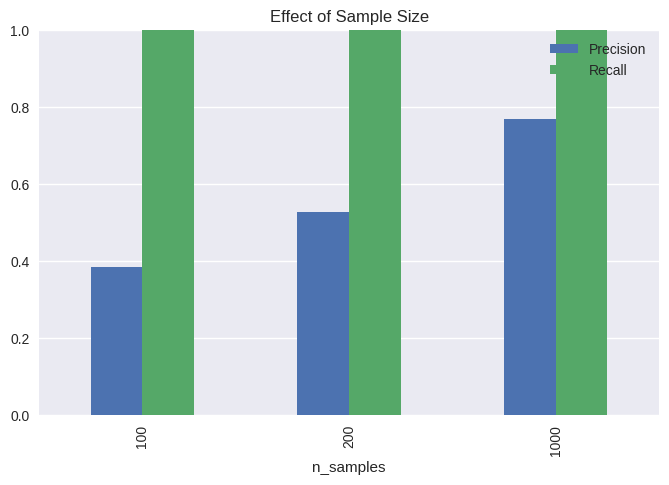

In [ ]:
sample_sizes = [100, 200, 1000]
n_features = 50
n_informative = 10
noise = 1.0

results = []

for n in sample_sizes:
    X = np.random.randn(n, n_features)
    beta = np.zeros(n_features)
    informative = np.random.choice(n_features, n_informative, replace=False)
    beta[informative] = np.random.randn(n_informative) * 3
    Y = X @ beta + np.random.randn(n) * noise

    precision, recall, _ = evaluate_lasso(X, Y, beta)
    results.append((n, precision, recall))

# Plotting
df1 = pd.DataFrame(results, columns=['n_samples', 'Precision', 'Recall'])
df1.plot(x='n_samples', y=['Precision', 'Recall'], kind='bar', figsize=(8, 5), title='Effect of Sample Size')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

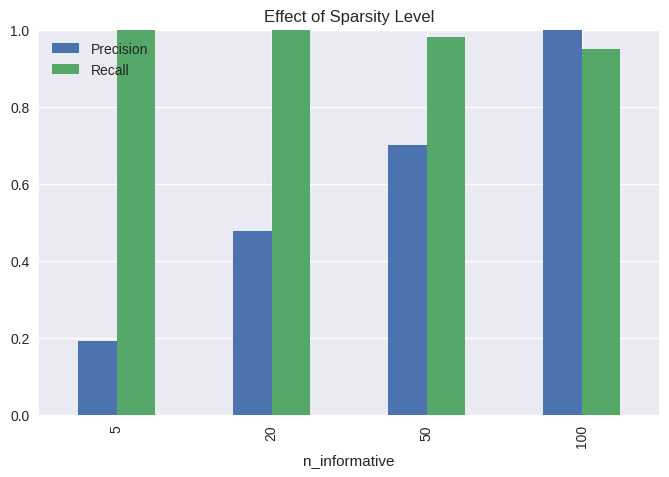

In [ ]:
sparsity_levels = [5, 20, 50, 100]
n_samples = 200
n_features = 100
noise = 1.0

results = []

for k in sparsity_levels:
    X = np.random.randn(n_samples, n_features)
    beta = np.zeros(n_features)
    informative = np.random.choice(n_features, k, replace=False)
    beta[informative] = np.random.randn(k) * 3
    Y = X @ beta + np.random.randn(n_samples) * noise

    precision, recall, _ = evaluate_lasso(X, Y, beta)
    results.append((k, precision, recall))

# Plotting
df2 = pd.DataFrame(results, columns=['n_informative', 'Precision', 'Recall'])
df2.plot(x='n_informative', y=['Precision', 'Recall'], kind='bar', figsize=(8, 5), title='Effect of Sparsity Level')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.datasets import make_regression

n_samples = 200
n_features = 50
n_informative = 10
noise = 1.0

# Generate correlated features using make_regression
X, Y, coef = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    noise=noise,
    coef=True,
    effective_rank=10,  # Low effective rank ⇒ high collinearity
    random_state=42
)

true_selected = coef != 0
precision, recall, _ = evaluate_lasso(X, Y, coef)

print(f"Correlated Features: Precision = {precision:.2f}, Recall = {recall:.2f}")


Correlated Features: Precision = 0.47, Recall = 0.90


1. More samples increase Precision and Recall
2. Increase sparsity (fewer informative features) makes LASSO works better
3. More correlated features cause collinearity, thus make LASSO less effective

In [ ]:
# Re-import necessary libraries due to code environment reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

def evaluate_lasso(X, Y, true_coefs, alpha=0.1):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, Y_train)

    selected = lasso.coef_ != 0
    true_selected = true_coefs != 0

    precision = precision_score(true_selected, selected, zero_division=0)
    recall = recall_score(true_selected, selected, zero_division=0)

    return precision, recall

# Ex1: Effect of Sample Size

In [ ]:
# Exercise 1: Effect of Sample Size
sample_sizes = [100, 200, 1000]
n_features = 50
n_informative = 10
noise = 1.0
results_ex1 = []

for n in sample_sizes:
    X = np.random.randn(n, n_features)
    beta = np.zeros(n_features)
    informative = np.random.choice(n_features, n_informative, replace=False)
    beta[informative] = np.random.randn(n_informative) * 3
    Y = X @ beta + np.random.randn(n) * noise
    precision, recall = evaluate_lasso(X, Y, beta)
    results_ex1.append((n, precision, recall))

df_ex1 = pd.DataFrame(results_ex1, columns=['n_samples', 'Precision', 'Recall'])

# Ex2: Different Sparsity Levels

In [ ]:
# Exercise 2: Different Sparsity Levels
sparsity_levels = [5, 20, 50, 100]
n_samples = 200
n_features = 100
results_ex2 = []

for k in sparsity_levels:
    X = np.random.randn(n_samples, n_features)
    beta = np.zeros(n_features)
    informative = np.random.choice(n_features, k, replace=False)
    beta[informative] = np.random.randn(k) * 3
    Y = X @ beta + np.random.randn(n_samples) * noise
    precision, recall = evaluate_lasso(X, Y, beta)
    results_ex2.append((k, precision, recall))

df_ex2 = pd.DataFrame(results_ex2, columns=['n_informative', 'Precision', 'Recall'])

In [ ]:
# Exercise 3: Correlated Features
X_corr, Y_corr, coef_corr = make_regression(
    n_samples=200,
    n_features=50,
    n_informative=10,
    noise=noise,
    coef=True,
    effective_rank=10,
    random_state=42
)

precision_corr, recall_corr = evaluate_lasso(X_corr, Y_corr, coef_corr)

(df_ex1, df_ex2, (precision_corr, recall_corr))

(   n_samples  Precision  Recall
 0        100   0.421053     0.8
 1        200   0.714286     1.0
 2       1000   0.833333     1.0,
    n_informative  Precision  Recall
 0              5   0.166667    0.60
 1             20   0.655172    0.95
 2             50   0.821429    0.92
 3            100   1.000000    0.90,
 (0.5294117647058824, 0.9))

In [ ]:
# Exercise 3: Correlated Features - Data Generation
n_samples = 200
n_features = 50
n_informative = 10
noise_level = 1.0
random_state = 42

# Create a correlation matrix
correlation_matrix = np.eye(n_features)

# Add some correlations between adjacent features for simplicity
for i in range(n_features - 1):
    correlation_matrix[i, i+1] = 0.6
    correlation_matrix[i+1, i] = 0.6

# Ensure the matrix is positive semi-definite
# A simple way is to add a small diagonal shift or use near_psd from scipy.linalg
# For simplicity here, we'll just check and inform if it's not (though random with off-diagonals might not be)
# In a real scenario, you'd use more robust methods or ensure PSD construction.
# As an alternative, you can generate data from a known covariance matrix that is PSD.

# Generate features using numpy.random.multivariate_normal
# We need the covariance matrix, which is related to the correlation matrix
# If features are scaled to unit variance, correlation = covariance
# We will assume features have variance 1 and the correlation matrix is the covariance matrix
try:
    # Generate data assuming the correlation matrix is the covariance matrix
    X_corr = np.random.multivariate_normal(np.zeros(n_features), correlation_matrix, size=n_samples)
except np.linalg.LinAlgError:
    print("Warning: Correlation matrix is not positive semi-definite. Results may be unexpected.")
    # Fallback to uncorrelated if multivariate_normal fails
    X_corr = np.random.randn(n_samples, n_features)


# Create the true coefficient vector (beta) - same as before
true_coefficients_corr = np.zeros(n_features)
# Randomly select which features will have non-zero coefficients
np.random.seed(random_state) # Ensure same informative features if needed
informative_features_corr = np.random.choice(n_features, n_informative, replace=False)

# Assign non-zero values to selected coefficients
np.random.seed(random_state + 1) # Use a different seed for coefficients
for idx in informative_features_corr:
    true_coefficients_corr[idx] = np.random.randn() * 3

# Generate the response variable Y - same as before
# Y = X * beta + noise
Y_corr = X_corr @ true_coefficients_corr + np.random.randn(n_samples) * noise_level

# Now evaluate Lasso on this correlated data
precision_corr, recall_corr = evaluate_lasso(X_corr, Y_corr, true_coefficients_corr)

print(f"\nResults with Correlated Features (Lasso α={evaluate_lasso.__defaults__[0]}):")
print(f"  Precision = {precision_corr:.4f}")
print(f"  Recall    = {recall_corr:.4f}")

# Note: The evaluate_lasso function defined previously splits data and scales within.
# If you want to compare MSE, you'd need to modify evaluate_lasso
# or add a separate evaluation block here.
# For this exercise focusing on feature selection, precision/recall is appropriate.


Results with Correlated Features (Lasso α=0.1):
  Precision = 0.4545
  Recall    = 1.0000


# Interpretation from comparing Lasso and Ridge

**1. Why does Lasso perform feature selection while Ridge doesn't?**

Lasso regression performs feature selection due to the nature of its regularization. In particular, Lasso applies an L1 penalty, which adds the absolute values of the coefficients to the loss function. This type of penalty encourages some coefficients to become exactly zero. As a result, Lasso not only reduces the magnitude of coefficients, but also removes some features from the model entirely.

In contrast, Ridge regression uses an L2 penalty, which adds the squares of the coefficients. This penalty reduces the size of all coefficients but does not set any of them to zero. Therefore, Ridge shrinks coefficients but retains all features in the model.

**2. In what situations would you prefer Lasso over Ridge?**

Lasso is preferred when the model is sparse, with fewer informative features. The situation is simulated in the Exercise 2.
It is especially useful when the number of features exceeds or is close to the number of observations. In such cases, Lasso helps to reduce overfitting and improve model interpretability by selecting a smaller subset of features.

However, when features are believed to contribute to the outcome and multicollinearity exists, Ridge is more appropriate. Meanwhile, Lasso show that the Precision decreases with the introduction of correlated features (Exhibited by Exercise 3).

**3. What are the limitations of Lasso for feature selection?**

When features are highly correlated, Lasso tends to select only one and ignore the others, which can lead to instability. It also introduces bias in the estimates of the non-zero coefficients due to the penalty.

Moreover, when the number of features exceeds the number of observations, Lasso can select at most as many features as there are observations, which may not be sufficient in some cases.

Lasso is also highly sensitive to the value of the regularization parameter (exhibited by comparison between different alphas), and small changes can lead to different sets of selected features. However, by tuning with Cross-Validation, it is possible to choose the optimal parameter alpha.

Finally, it does not perform well when relevant features are grouped, as it may eliminate important variables that belong to a useful group.